In [ ]:
!pip uninstall -y apache-beam chex momepy pymc3 ydata-profiling
!pip install numpy==1.23.5

In [47]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import math
import eli5

#dataset pre-processing realated imports
import sklearn
from eli5.sklearn import PermutationImportance
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



#imports related to classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
#DNN imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Explainability imports
from sklearn.inspection import PartialDependenceDisplay


In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print('Done!')

/kaggle/input/fwaf-dataset/payload_full.csv
Done!


* **Reading the csv file**

In [49]:
fwaf_filepath='/kaggle/input/fwaf-dataset/payload_full.csv'
fwaf_data=pd.read_csv(fwaf_filepath)
print('Done!')

Done!


In [50]:
n_features=fwaf_data.shape[1]
n_samples =fwaf_data.shape[0]


print("Number of samples:", n_samples)
print("Number of features:", n_features)

Number of samples: 31067
Number of features: 4


In [51]:
fwaf_data.head()

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,40184,5,norm,norm
3,1442431887503330,16,norm,norm
4,nue37,5,norm,norm


In [52]:
fwaf_data.tail()

,payload,length,attack_type,label
31062,"<script a="">"" id=xss src=""http://ha.ckers.org/...",63,xss,anom
31063,"<script a="">"" '' id=xss src=""http://ha.ckers.o...",66,xss,anom
31064,"<script ""a='>'"" id=xss src=""http://ha.ckers.or...",65,xss,anom
31065,"<script a=`>` id=xss src=""http://ha.ckers.org/...",63,xss,anom
31066,"<script>document.write(""<scri"");</script>pt id...",93,xss,anom


In [53]:
fwaf_data.columns

Index(['payload', 'length', 'attack_type', 'label'], dtype='object')

In [54]:
fwaf_data.head()

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,40184,5,norm,norm
3,1442431887503330,16,norm,norm
4,nue37,5,norm,norm


# **Data Visualization**

<Axes: xlabel='label', ylabel='count'>

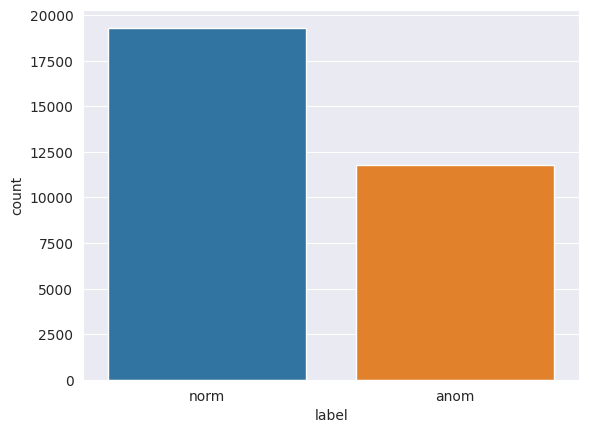

In [55]:
sns.set_style('darkgrid')
sns.countplot(data= fwaf_data, x='label')

In [56]:
feature_names=[ 'payload', 'length', 'attack_type', 'label']

X=fwaf_data[feature_names]
print(X)

                                                 payload  length attack_type  \
0                                         c/ caridad s/n      14        norm   
1                                           campello, el      12        norm   
2                                                  40184       5        norm   
3                                       1442431887503330      16        norm   
4                                                  nue37       5        norm   
...                                                  ...     ...         ...   
31062  <script a=">" id=xss src="http://ha.ckers.org/...      63         xss   
31063  <script a=">" '' id=xss src="http://ha.ckers.o...      66         xss   
31064  <script "a='>'" id=xss src="http://ha.ckers.or...      65         xss   
31065  <script a=`>` id=xss src="http://ha.ckers.org/...      63         xss   
31066  <script>document.write("<scri");</script>pt id...      93         xss   

      label  
0      norm  
1      norm

# **Preprocessing [on column payload]** 

In [57]:
print(X.payload)

0                                           c/ caridad s/n
1                                             campello, el
2                                                    40184
3                                         1442431887503330
4                                                    nue37
                               ...                        
31062    <script a=">" id=xss src="http://ha.ckers.org/...
31063    <script a=">" '' id=xss src="http://ha.ckers.o...
31064    <script "a='>'" id=xss src="http://ha.ckers.or...
31065    <script a=`>` id=xss src="http://ha.ckers.org/...
31066    <script>document.write("<scri");</script>pt id...
Name: payload, Length: 31067, dtype: object


In [58]:
X['payload'] = X['payload'].astype(str)
X['payload'] = X['payload'].str.extract(r'(\d+)')
X['payload'] = pd.to_numeric(X['payload'], errors='coerce').fillna(0)
print(X.payload)

0        0.000000e+00
1        0.000000e+00
2        4.018400e+04
3        1.442432e+15
4        3.700000e+01
             ...     
31062    0.000000e+00
31063    0.000000e+00
31064    0.000000e+00
31065    0.000000e+00
31066    0.000000e+00
Name: payload, Length: 31067, dtype: float64


In [59]:
X['attack_type'] = X['attack_type'].astype(str)
X['attack_type'] = X['attack_type'].str.extract(r'(\d+)')
X['attack_type'] = pd.to_numeric(X['attack_type'], errors='coerce').fillna(0)
print(X.attack_type)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
31062    0.0
31063    0.0
31064    0.0
31065    0.0
31066    0.0
Name: attack_type, Length: 31067, dtype: float64


In [60]:
filtered_length = X.loc[X['attack_type'] == 'norm', 'length']
print(filtered_length)

Series([], Name: length, dtype: int64)


In [61]:
X['length'] = X['length'].astype(str)
X['length'] = X['length'].str.extract(r'(\d+)')
X['length'] = pd.to_numeric(X['length'], errors='coerce').fillna(0)
print(X.length)

0        14
1        12
2         5
3        16
4         5
         ..
31062    63
31063    66
31064    65
31065    63
31066    93
Name: length, Length: 31067, dtype: int64


# **Building final dataset to be used for classification**

In [62]:
y=X['label']
print(y)

0        norm
1        norm
2        norm
3        norm
4        norm
         ... 
31062    anom
31063    anom
31064    anom
31065    anom
31066    anom
Name: label, Length: 31067, dtype: object


In [63]:
X['label'] = X['label'].astype(str)
X['label'] = X['label'].str.extract(r'(\d+)')
X['label'] = pd.to_numeric(X['label'], errors='coerce').fillna(0)
print(X.label)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
31062    0.0
31063    0.0
31064    0.0
31065    0.0
31066    0.0
Name: label, Length: 31067, dtype: float64


In [64]:
labels=['payload', 'length', 'attack_type']
print(X[labels])

            payload  length  attack_type
0      0.000000e+00      14          0.0
1      0.000000e+00      12          0.0
2      4.018400e+04       5          0.0
3      1.442432e+15      16          0.0
4      3.700000e+01       5          0.0
...             ...     ...          ...
31062  0.000000e+00      63          0.0
31063  0.000000e+00      66          0.0
31064  0.000000e+00      65          0.0
31065  0.000000e+00      63          0.0
31066  0.000000e+00      93          0.0

[31067 rows x 3 columns]


In [65]:
print('computing...')
#split dataset in test and train 
x_tr, x_ts, y_tr, y_ts = train_test_split(X[labels], y, test_size=0.3, random_state=0)


print('Done!')

computing...
Done!


In [66]:
x_tr.head(5)

,payload,length,attack_type
15988,1.0,80,0.0
14350,1.0,82,0.0
17252,1.0,84,0.0
9196,9516.0,4,0.0
14690,1.0,85,0.0


In [67]:
x_tr.tail(5)

,payload,length,attack_type
13123,1.0,137,0.0
19648,0.0,9,0.0
9845,127.0,16,0.0
10799,1.0,114,0.0
2732,65223156.0,9,0.0


# **Classifiers**

In [68]:
random_forest_model = RandomForestClassifier(random_state=1000)
print('Computing....')
# Fit the model
random_forest_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [69]:
RT_predictions= random_forest_model.predict(x_ts)

print("Accuracy", accuracy_score(y_ts, RT_predictions))
print("Precision", precision_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_rt))

Accuracy 0.9846582984658299
Precision 0.9847382218498759
Recall 0.9846582984658299
F1 0.9846222703346302
Test error: 1.5%


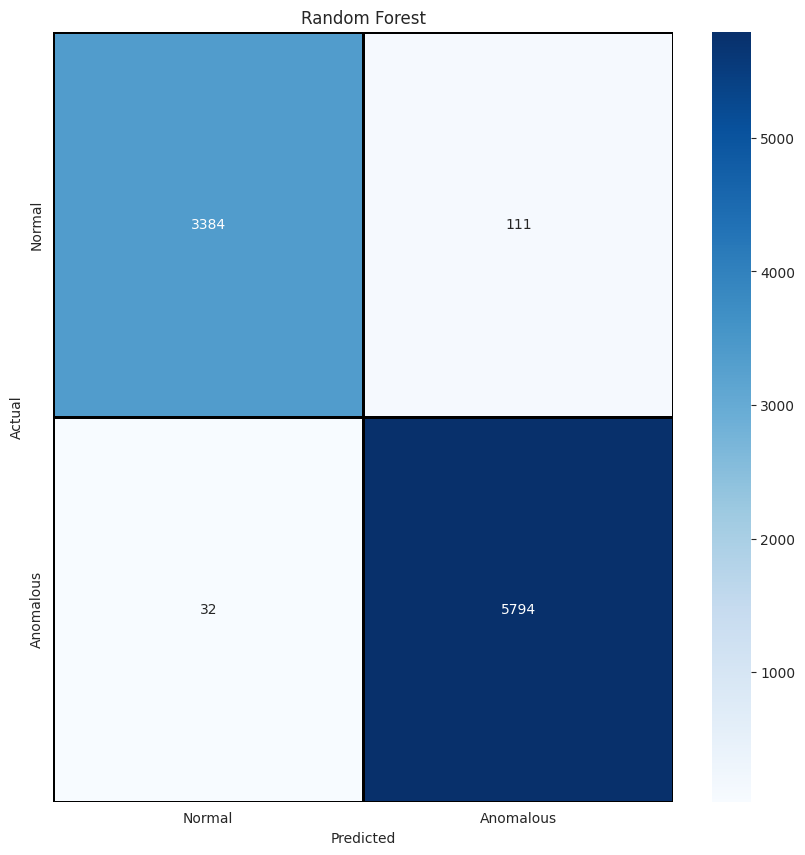

In [70]:
label = ['Normal', 'Anomalous']
cm = confusion_matrix(y_ts, RT_predictions)
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=label, yticklabels=label)
plt.title("Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**K-NEAREST NEIGHBOR**

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#knn_model = KNeighborsClassifier()

#param_grid = {'n_neighbors': [3, 5, 7, 9,10,11, 13]}

#grid_search = GridSearchCV(knn_model, param_grid, cv=5)
#grid_search.fit(x_tr, y_tr)

#best_n_neighbors = grid_search.best_params_['n_neighbors']
#print("Best n_neighbors:", best_n_neighbors)

#final_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
#final_model.fit(x_tr, y_tr)

#knn_predictions = final_model.predict(x_ts)

In [72]:
final_model = KNeighborsClassifier(n_neighbors=9)
final_model.fit(x_tr, y_tr)
knn_predictions = final_model.predict(x_ts)

In [73]:
print("Accuracy", accuracy_score(y_ts, knn_predictions))
print("Precision", precision_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("Recall", recall_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("F1", f1_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
error_knn = (knn_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_knn))

Accuracy 0.971033150949469
Precision 0.9710935389556682
Recall 0.971033150949469
F1 0.9709480034867098
Test error: 2.9%


<Axes: title={'center': 'KN Neighbors'}>

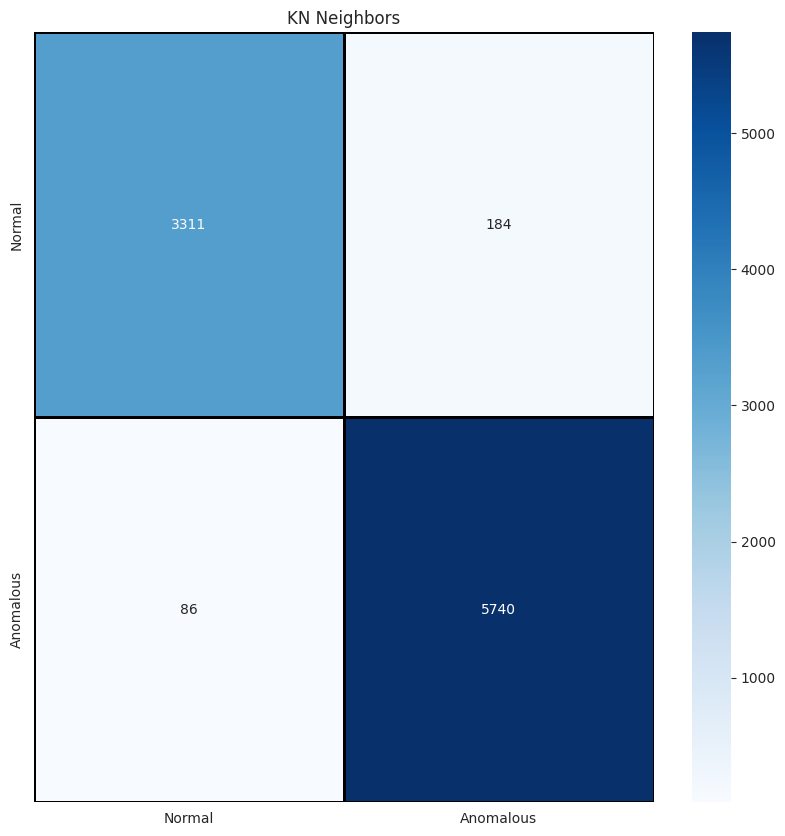

In [74]:
cm = confusion_matrix(y_ts,knn_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
plt.title("KN Neighbors")
plt.xlabel("Predicted")
plt.ylabel("Act")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**DECISION TREE**


In [83]:
DT_model = DecisionTreeClassifier(random_state=2)
print('Computing....')
DT_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [84]:
DT_predictions= DT_model.predict(x_ts)
print("Accuracy", accuracy_score(y_ts, DT_predictions))
print("Precision", precision_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("Recall", recall_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("F1", f1_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
error_dt = (DT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_dt))

Accuracy 0.9843364445874906
Precision 0.9844119252648604
Recall 0.9843364445874906
F1 0.9843001434687978
Test error: 1.6%


<Axes: title={'center': 'Decision Tree'}>

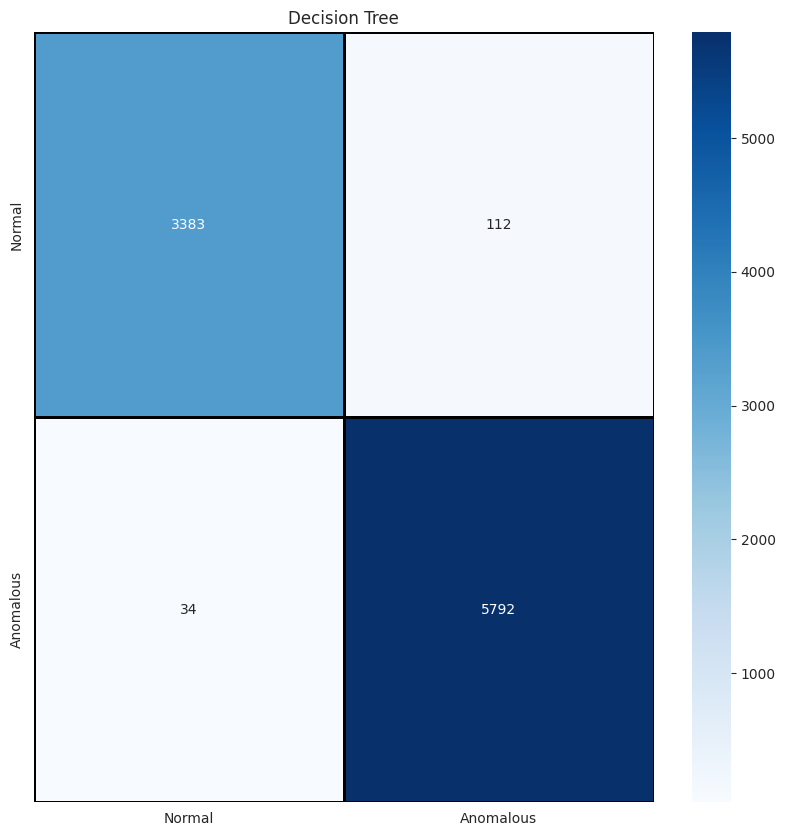

In [85]:
cm = confusion_matrix(y_ts, DT_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
plt.title("Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Act")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Logistic Regression**

In [86]:
LR_model = LogisticRegression(random_state = 42)
print('Computing....')
LR_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
LR_predictions= LR_model.predict(x_ts)
print("Accuracy", accuracy_score(y_ts, LR_predictions))
print("Precision", precision_score(y_ts, LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
print("Recall", recall_score(y_ts, LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
print("F1", f1_score(y_ts, LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
error_lr = (LR_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_lr))

Accuracy 0.3749597682652076
Precision 0.37495976826520755
Recall 1.0
F1 0.5454119850187267
Test error: 62.5%


<Axes: title={'center': 'Logistic Regression'}>

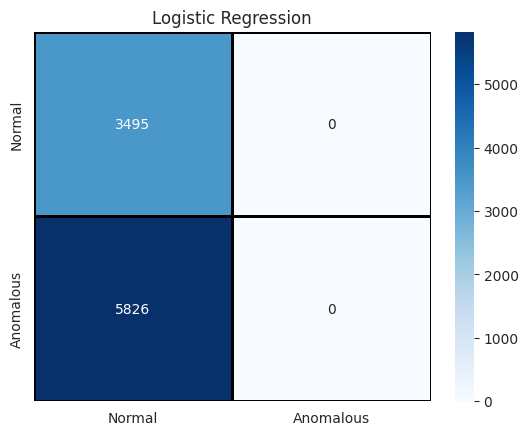

In [88]:
cm = confusion_matrix(y_ts,LR_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Support Vector Machine (SVM)**

In [89]:
SVC_model = SVC()
print('Computing....') 
SVC_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [90]:
SVC_predictions= SVC_model.predict(x_ts)
print("Accuracy", accuracy_score(y_ts, SVC_predictions))
print("Precision", precision_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("Recall", recall_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("F1", f1_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
error_svc = (SVC_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_svc))

Accuracy 0.6250402317347924
Precision 0.6250402317347924
Recall 1.0
F1 0.769261239849475
Test error: 37.5%


<Axes: title={'center': 'SVC'}>

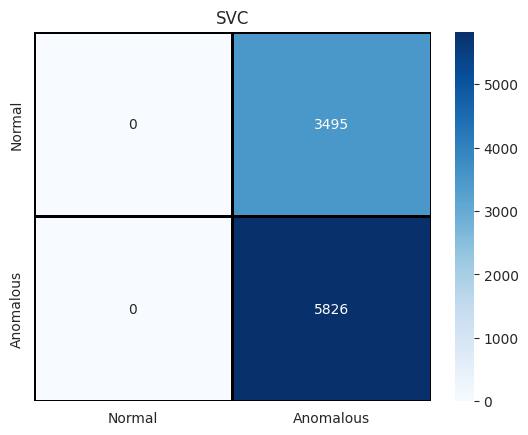

In [91]:
cm = confusion_matrix(y_ts,SVC_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Naïves Bayes**

In [92]:
NB_model = GaussianNB ()
print('Computing....')
NB_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [93]:
NB_predictions= NB_model.predict(x_ts)
print("Accuracy", accuracy_score(y_ts, NB_predictions))
print("Precision", precision_score(y_ts, NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
print("Recall", recall_score(y_ts, NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
print("F1", f1_score(y_ts, NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
error_nb = (NB_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_nb))

Accuracy 0.42484711940778885
Precision 0.7730172405521931
Recall 0.42484711940778885
F1 0.3046068534814996
Test error: 57.5%


<Axes: title={'center': 'NB'}>

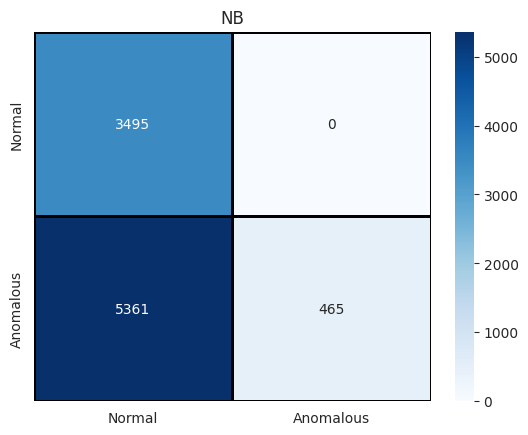

In [94]:
cm = confusion_matrix(y_ts,NB_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("NB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)